# Import

## Dependencies

In [1]:
import time
import numpy as np
import pandas as pd
start_time = time.time()
from tqdm import tqdm
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

## Data

In [2]:
# Load np array
features = np.load('../10_data/features.npy', allow_pickle=True)

bags_train = np.load('../10_data/bags.npy', allow_pickle=True)
id_bags_train = np.load('../10_data/id_bags.npy', allow_pickle=True)
date_bags_train = np.load('../10_data/date_bags.npy', allow_pickle=True)
y_round_up_bag_train = np.load('../10_data/y_round_up_bag.npy', allow_pickle=True).astype('int')
y_ins_train = np.load('../10_data/y_ins.npy', allow_pickle=True)

In [3]:
def print_data_stats(list_x, list_y):
    print('- There are {} bags'.format(len(list_x)))
    print('- There are {} labels with values [{}]'.format(len(list_y), ', '.join([str(i) for i in np.unique(list_y)])))
    
    bags_len = [len(i) for i in list_x]
    print('- Bags length varies between {} and {}'.format(min(bags_len), max(bags_len)))
    
    elem_len = [len(e) for sl in list_x for e in sl]
    print('- Element length varies between {} and {}'.format(min(elem_len), max(elem_len)))

print('Training set:')
print_data_stats(bags_train, y_round_up_bag_train)

Training set:
- There are 13813 bags
- There are 13813 labels with values [0, 1]
- Bags length varies between 1 and 78
- Element length varies between 14 and 14


## Example

In [4]:
def draw_example(df_bags, df_bags_ins, df_bags_y_round_up, df_bag_id, df_bag_date=None):
    bag_idx = np.random.randint(0, len(df_bags))
    print('Selected bag with id {}'.format(bag_idx))
    if df_bag_date is not None:
        print('Selected bag with date {}'.format(df_bag_date[bag_idx]))
    print('{} invoice lines'.format(len(df_bags[bag_idx])))
    
    print_bag_details(bag_idx, df_bags_ins, df_bags_y_round_up, df_bag_id)
    
    return bag_idx

def print_bag_details(bag_idx, df_bags_ins, df_bags_y_round_up, df_bag_id, search_admin_customer=False):
    print('bag label \'Round up\' = {}'.format(df_bags_y_round_up[bag_idx]))
    print('instance labels = {}'.format(df_bags_ins[bag_idx]))
    print('Invoice nr = {}'.format(df_bag_id[bag_idx]))

    if search_admin_customer:
        from admin import admin_sql
        cnxn_sql = admin_sql.AdminSql(r'C:\Users\Ward.RFN\Downloads\credentials\AdminSQL_Credentials_Production.json')
        print('Customer Id = {}'.format(cnxn_sql.sql_query('SELECT CUSTOMER_ID FROM DBA.INVOICE WHERE INVOICE_NR = \'{}\''.format(df_bag_id[bag_idx]))['CUSTOMER_ID'].iloc[0]))

bag_idx = draw_example(bags_train, y_ins_train, y_round_up_bag_train, id_bags_train, date_bags_train)

Selected bag with id 4939
Selected bag with date [2021 5 22]
16 invoice lines
bag label 'Round up' = 1
instance labels = ['ROUND_UP' 'NONE' 'NONE' 'NONE' 'NONE' 'NONE' 'NONE' 'NONE' 'NONE' 'NONE'
 'ROUND_DOWN' 'OTHER' 'ROUND_DOWN' 'NONE' 'NONE' 'OTHER']
Invoice nr = 2107698


In [5]:
y_ins_train[bag_idx]

array(['ROUND_UP', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE',
       'NONE', 'NONE', 'ROUND_DOWN', 'OTHER', 'ROUND_DOWN', 'NONE',
       'NONE', 'OTHER'], dtype=object)

In [6]:
pd.DataFrame(data=bags_train[bag_idx], columns=features).head()

,INVOICE_RATE_HOUR,REG_OBJECT_INVOICED,REMARK_LENGTH,INTERNAL_REMARK_LENGTH,LINE_TARIFF,LINE_ORIGINAL_QUANTITY,F_PRESTATION_BY_PM,F_COLLEAGUE_EXP_DAYS,F_PM_EXP_DAYS,F_DISTANCE_5_MIN,F_DISTANCE_10_MIN,F_DIFF_SELL_TO_CUST,PROJECT_TYPE_DESCRIPTION_Dossier Compta,PROJECT_TYPE_DESCRIPTION_Dossier Social
0,79.514809,1.0,184.0,0.0,83.199997,5.0,1.0,463.0,463.0,0.0,1.0,0.0,1.0,0.0
1,79.514809,1.0,73.0,0.0,83.199997,10.0,1.0,471.0,471.0,1.0,0.0,0.0,1.0,0.0
2,79.514809,1.0,63.0,0.0,108.500000,30.0,0.0,4693.0,472.0,0.0,0.0,0.0,1.0,0.0
3,79.514809,1.0,128.0,31.0,83.199997,60.0,1.0,462.0,462.0,0.0,0.0,0.0,1.0,0.0
4,79.514809,1.0,121.0,0.0,83.199997,145.0,0.0,230.0,471.0,1.0,0.0,0.0,1.0,0.0


# Limit dataset size

In [7]:
invoice_months = np.array([i[1] for i in date_bags_train])
pd.DataFrame(np.unique(invoice_months, return_counts=True))

,0,1,2,3,4,5,6,7,8,9,10,11
0,1,2,3,4,5,6,7,8,9,10,11,12
1,1078,1073,1105,1457,731,1305,1249,986,1105,1276,1262,1186


In [8]:
bags_train_1 = bags_train[invoice_months == 1]
id_bags_train_1 = id_bags_train[invoice_months == 1]
y_round_up_bag_train_1 = y_round_up_bag_train[invoice_months == 1]
y_ins_train_1 = y_ins_train[invoice_months == 1]

bags_train_2 = bags_train[invoice_months == 2]
id_bags_train_2 = id_bags_train[invoice_months == 2]
y_round_up_bag_train_2 = y_round_up_bag_train[invoice_months == 2]
y_ins_train_2 = y_ins_train[invoice_months == 2]

# Pipeline components

## StandarizerBagsList

In [9]:
from preprocessing.standarize_bags import StandarizerBagsList

bag_standardizer = StandarizerBagsList()

start_time = time.time()
bag_standardizer.fit(bags_train_1)
print("Standardizer fitting time: {:.2f} sec".format(time.time() - start_time))

# Print average and stdev time registration
pd.DataFrame(data=[bag_standardizer.mean, bag_standardizer.std], columns=features)

Standardizer fitting time: 0.02 sec


,INVOICE_RATE_HOUR,REG_OBJECT_INVOICED,REMARK_LENGTH,INTERNAL_REMARK_LENGTH,LINE_TARIFF,LINE_ORIGINAL_QUANTITY,F_PRESTATION_BY_PM,F_COLLEAGUE_EXP_DAYS,F_PM_EXP_DAYS,F_DISTANCE_5_MIN,F_DISTANCE_10_MIN,F_DIFF_SELL_TO_CUST,PROJECT_TYPE_DESCRIPTION_Dossier Compta,PROJECT_TYPE_DESCRIPTION_Dossier Social
0,94.539965,0.0,102.660429,11.760481,88.846846,41.692629,0.0,2037.442760,1859.773968,0.0,0.0,0.0,0.0,0.0
1,44.500064,1.0,73.817756,33.158868,10.582455,69.764743,1.0,1869.067972,1484.354047,1.0,1.0,1.0,1.0,1.0


### Example

In [10]:
bag_idx = draw_example(bags_train_2, y_round_up_bag_train_2, id_bags_train_2, id_bags_train_2)

Selected bag with id 800
24 invoice lines
bag label 'Round up' = 21005138
instance labels = 0
Invoice nr = 21005138


In [11]:
# Show example bag
pd.DataFrame(data=bags_train_2[bag_idx], columns=features).head(3)

,INVOICE_RATE_HOUR,REG_OBJECT_INVOICED,REMARK_LENGTH,INTERNAL_REMARK_LENGTH,LINE_TARIFF,LINE_ORIGINAL_QUANTITY,F_PRESTATION_BY_PM,F_COLLEAGUE_EXP_DAYS,F_PM_EXP_DAYS,F_DISTANCE_5_MIN,F_DISTANCE_10_MIN,F_DIFF_SELL_TO_CUST,PROJECT_TYPE_DESCRIPTION_Dossier Compta,PROJECT_TYPE_DESCRIPTION_Dossier Social
0,77.858025,1.0,129.0,185.0,108.5,60.0,0.0,84.0,153.0,0.0,0.0,0.0,0.0,1.0
1,77.858025,1.0,35.0,10.0,108.5,5.0,0.0,1162.0,153.0,0.0,1.0,0.0,0.0,1.0
2,77.858025,1.0,357.0,201.0,108.5,145.0,0.0,85.0,154.0,1.0,0.0,0.0,0.0,1.0


In [12]:
# Transfrom one bag
pd.DataFrame(data=bag_standardizer.transform([bags_train_2[bag_idx]])[0], columns=features).head(3)

,INVOICE_RATE_HOUR,REG_OBJECT_INVOICED,REMARK_LENGTH,INTERNAL_REMARK_LENGTH,LINE_TARIFF,LINE_ORIGINAL_QUANTITY,F_PRESTATION_BY_PM,F_COLLEAGUE_EXP_DAYS,F_PM_EXP_DAYS,F_DISTANCE_5_MIN,F_DISTANCE_10_MIN,F_DIFF_SELL_TO_CUST,PROJECT_TYPE_DESCRIPTION_Dossier Compta,PROJECT_TYPE_DESCRIPTION_Dossier Social
0,-0.374875,1.0,0.356819,5.224531,1.857145,0.262416,0.0,-1.045143,-1.149843,0.0,0.0,0.0,0.0,1.0
1,-0.374875,1.0,-0.916587,-0.053092,1.857145,-0.525948,0.0,-0.468385,-1.149843,0.0,1.0,0.0,0.0,1.0
2,-0.374875,1.0,3.445507,5.707056,1.857145,1.480796,0.0,-1.044608,-1.149169,1.0,0.0,0.0,0.0,1.0


### Standardize data set

In [13]:
start_time = time.time()
bags_train_1_std = bag_standardizer.transform(bags_train_1)
print("Standardizer transform time (train set): {:.2f} sec".format(time.time() - start_time))

start_time = time.time()
bags_train_2_std = bag_standardizer.transform(bags_train_2)
print("Standardizer transform time (validation set): {:.2f} sec".format(time.time() - start_time))

Standardizer transform time (train set): 0.02 sec
Standardizer transform time (validation set): 0.02 sec


## MILESMapping

In [14]:
from bag_representation.miles_mapping import *

bag_miles_mapping = MILESMapping(sigma2=4.5**2, return_iip_bag_closest=True)


start_time = time.time()
bag_miles_mapping.fit(bags_train_1_std)
print("MILES Mapping fitting time: {:.2f} sec".format(time.time() - start_time))

MILES Mapping fitting time: 0.00 sec


### Example

In [20]:
bag_idx = draw_example(bags_train_2_std, y_round_up_bag_train_2, id_bags_train_2, id_bags_train_2)

Selected bag with id 465
8 invoice lines
bag label 'Round up' = 2102656
instance labels = 0
Invoice nr = 2102656


In [21]:
# Show example bag
pd.DataFrame(data=bags_train_2_std[bag_idx], columns=features).head(3)

,INVOICE_RATE_HOUR,REG_OBJECT_INVOICED,REMARK_LENGTH,INTERNAL_REMARK_LENGTH,LINE_TARIFF,LINE_ORIGINAL_QUANTITY,F_PRESTATION_BY_PM,F_COLLEAGUE_EXP_DAYS,F_PM_EXP_DAYS,F_DISTANCE_5_MIN,F_DISTANCE_10_MIN,F_DIFF_SELL_TO_CUST,PROJECT_TYPE_DESCRIPTION_Dossier Compta,PROJECT_TYPE_DESCRIPTION_Dossier Social
0,-0.422891,1.0,-0.862400,-0.354671,1.809897,-0.382609,0.0,-0.973449,-1.035315,0.0,0.0,0.0,1.0,0.0
1,-0.422891,1.0,-0.659197,-0.354671,1.857145,-0.167601,0.0,-0.941883,-1.157927,0.0,0.0,0.0,1.0,0.0
2,-0.422891,1.0,0.939335,0.037381,-0.571403,-0.382609,1.0,-0.917807,-1.035989,0.0,0.0,0.0,1.0,0.0


In [ ]:
# Transfrom one bag
test, test_closest = bag_miles_mapping.transform([bags_train_2_std[bag_idx]])
test, test_closest = test[0], test_closest[0] 
print('length = {}; max = {:.2f}; min = {:.2f}'.format(len(test), test.max(), test.min()))
test

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 62.51it/s]

length = 9565; max = 1.00; min = 0.00


array([0.78455988, 0.81967869, 0.82827194, ..., 0.86680364, 0.88928543,
       0.81395576])

In [23]:
from utils.utils import bags2instances

# Intermediary instance pool
iip = bags2instances(bags_train_1)

# Show similar lines from iip compared with example bag
print('{} lines in iip are similar to one of the lines of this bag.'.format(len(np.where(test > .999)[0])))
pd.DataFrame(data=iip[np.where(test > .999)], columns=features).head(50)

2 lines in iip are similar to one of the lines of this bag.


,INVOICE_RATE_HOUR,REG_OBJECT_INVOICED,REMARK_LENGTH,INTERNAL_REMARK_LENGTH,LINE_TARIFF,LINE_ORIGINAL_QUANTITY,F_PRESTATION_BY_PM,F_COLLEAGUE_EXP_DAYS,F_PM_EXP_DAYS,F_DISTANCE_5_MIN,F_DISTANCE_10_MIN,F_DIFF_SELL_TO_CUST,PROJECT_TYPE_DESCRIPTION_Dossier Compta,PROJECT_TYPE_DESCRIPTION_Dossier Social
0,74.181183,1.0,49.0,0.0,83.199997,10.0,1.0,117.0,117.0,1.0,0.0,0.0,1.0,0.0
1,76.430435,1.0,46.0,0.0,83.199997,10.0,1.0,234.0,234.0,1.0,0.0,0.0,1.0,0.0


### Apply MILES Mapping on data set

In [25]:
bags_train_std_miles, bags_train_std_miles_closest = bag_miles_mapping.transform(bags_train_1_std)

bags_validation_std_miles, bags_validation_std_miles_closest = bag_miles_mapping.transform(bags_train_2_std)

100%|██████████████████████████████████████████████████████████████████████████████| 1073/1073 [00:20<00:00, 53.02it/s]


## Oversample

Oversampling has the very same effect as introducing a Misclassification Cost Matrix. Oversampling is the easier approach as we don't need to alter the algorithm. We prefer to work on the data level rather than the algorithm level

731 positive bags (invoices)


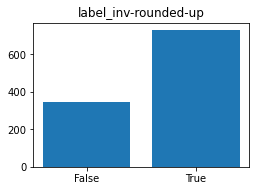

In [27]:
def print_label_balance(labels):
    print("{} positive bags (invoices)".format(labels[labels == 1].shape[0]))

    fig = plt.figure(figsize=(3, 2))
    ax = fig.add_axes([0,0,1,1])
    ax.bar([True, False], [labels[labels == 1].shape[0], labels[labels == 0].shape[0]], tick_label=[True, False])
    ax.set(title='label_inv-rounded-up')
    plt.show()

print_label_balance(y_round_up_bag_train_1)

In [28]:
from imblearn.over_sampling import SMOTE

def oversample_smote(X, y, balance):
    oversample = SMOTE(sampling_strategy = balance, random_state = 0, k_neighbors = 3)
    X, y = oversample.fit_resample(X, y)
    return X, y

In [29]:
#bags_train_std_miles_oversampled, y_bag_train_oversampled = oversample_smote(bags_train_std_miles, y_bag_train, 1)
#print_label_balance(y_bag_train_oversampled)

## Model: Random forest

In [68]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, confusion_matrix

def model_evaluation(y, y_predicted, min_recall=.95, prob_col=1):
    y_predicted = np.array([float(i) for i in y_predicted.iloc[:, prob_col]])
    
    #Get ROC values for entire validation set
    fpr, tpr, _ = roc_curve(y_true=y, y_score=y_predicted)
    print("AUC = {}".format(roc_auc_score(y, y_predicted)))
    
    # Get Precision/Recall
    precision, recall, thresholds = precision_recall_curve(y_true=y, probas_pred=y_predicted)
    thresholds = [0] + thresholds.tolist()
    min_recall_threshold = thresholds[np.abs(recall - min_recall).argmin()]
    
    # Calulate specificity at this rate
    tn, fp, fn, tp = confusion_matrix(y, y_predicted>min_recall_threshold).ravel()
    specificity = (tn / (tn+fp))*100
    
    print('Recall of {:.2f} % reached on {:.3f} threshold. This equals a {:.3f}  % precision'.format(min_recall*100, min_recall_threshold, specificity))
    
    # Create figure
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5), dpi=80)
    
    # Figure 1 - ROC
    axs[0].plot(fpr, tpr, lw=1, color='black')
    axs[0].plot([0, 1], [0, 1], color='black', linestyle='dashed')
    axs[0].set(xlabel='False Positive Rate', ylabel='True Positive Rate', title='ROC', xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
    
    # Figure 2 - Precision/Recall
    axs[1].plot(recall, precision, lw=1, color='black')
    axs[1].set(xlabel='Recall', ylabel='Precision', title='Precision/Recall', xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
    
    # Figure 3 - Precision/Recall
    axs[2].plot(thresholds, precision, label='precision', lw=1, color='black', ls='dotted')
    axs[2].plot(thresholds, recall, label='recall', lw=1, color='black', ls='dashed')
    axs[2].axhline(min_recall, lw=1, color='red')
    axs[2].axvline(min_recall_threshold, ls='--', lw=1, color='black')
    axs[2].legend()
    axs[2].set(xlabel='Threshold', ylabel='Recall/Precision', title='Precision/Recall', xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
    
    return min_recall_threshold, specificity

### Fit RF Model

In [32]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=800, max_depth=10, random_state=None, max_features='auto', bootstrap=True, n_jobs=-1)

start_time = time.time()
rf.fit(X=bags_train_std_miles, y=y_round_up_bag_train_1)
print("RandomForest fitting time: {:.2f} sec".format(time.time() - start_time))

C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomForest fitting time: 6.28 sec


### Evaluate on Validation set

In [33]:
start_time = time.time()
y_bag_validation_pred = pd.DataFrame(rf.predict_proba(bags_validation_std_miles))
print("RandomForest prediction time (validation set): {:.2f} sec".format(time.time() - start_time))

RandomForest prediction time (validation set): 0.32 sec


AUC = 0.7065465384000056
Recall of 95.00 % reached on 0.404 threshold. This equals a 21.002  % precision


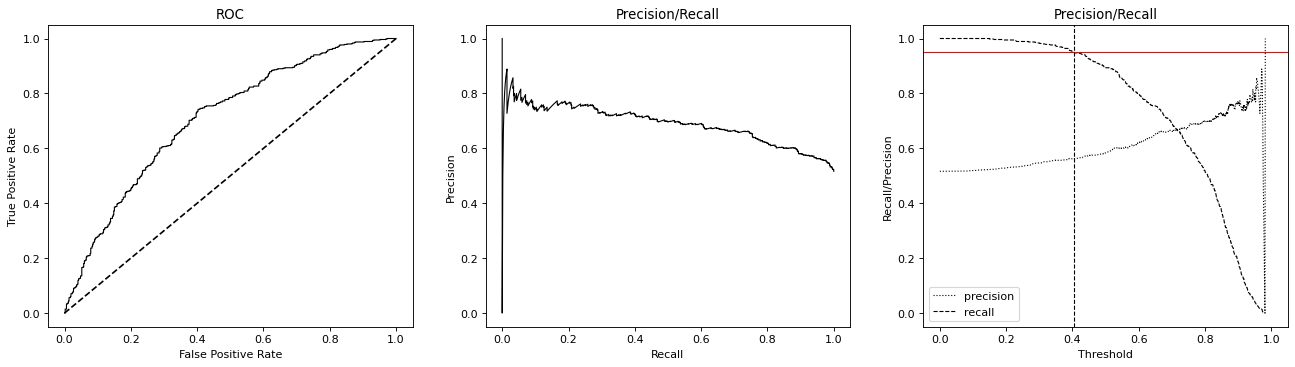

In [69]:
min_threshold, specificity = model_evaluation(y_round_up_bag_train_2, y_bag_validation_pred)

In [53]:
from sklearn.metrics import confusion_matrix

threshold = min_threshold #0.2

pd.DataFrame(confusion_matrix(y_round_up_bag_train_2, y_bag_validation_pred.iloc[:, 1]>threshold, normalize='true'), columns=['PRED_FALSE', 'PRED_TRUE'], index=['ACTUAL_FALSE', 'ACTUAL_TRUE'])

,PRED_FALSE,PRED_TRUE
ACTUAL_FALSE,0.210019,0.789981
ACTUAL_TRUE,0.050542,0.949458


In [54]:
np.unique(y_round_up_bag_train_2, return_counts=True)

(array([0, 1]), array([519, 554], dtype=int64))

In [66]:
pd.DataFrame(confusion_matrix(y_round_up_bag_train_2, y_bag_validation_pred.iloc[:, 1]>threshold), columns=['PRED_FALSE', 'PRED_TRUE'], index=['ACTUAL_FALSE', 'ACTUAL_TRUE'])

,PRED_FALSE,PRED_TRUE
ACTUAL_FALSE,109,410
ACTUAL_TRUE,28,526


In [37]:
raise(Exception('Stop'))

Exception: Stop

# Admin queries

In [ ]:
from admin import admin_sql

cnxn_admin_sql = admin_sql.AdminSql(r'C:\Users\Ward.RFN\Downloads\credentials\AdminSQL_Credentials_Production.json')

df = cnxn_admin_sql.sql_query('''
                                SELECT i.INVOICE_NR, i.INVOICE_DATE, ild.*
                                FROM DBA.INVOICE i
                                LEFT JOIN DBA.INVOICE_LINES ild ON i.INVOICE_ID = ild.INVOICE_ID
                                WHERE i.INVOICE_ID = '589271' ''')
df.head()

In [ ]:
589271

# Search CustomerId via InvoiceNR

In [ ]:
from admin import admin_sql
invoice_nr = 2207804
print('Invoice nr = {}'.format(invoice_nr))
cnxn_sql = admin_sql.AdminSql(r'C:\Users\Ward.RFN\Downloads\credentials\AdminSQL_Credentials_Production.json')
print('Customer Id = {}'.format(cnxn_sql.sql_query('SELECT CUSTOMER_ID FROM DBA.INVOICE WHERE INVOICE_NR = \'{}\''.format(invoice_nr))['CUSTOMER_ID'].iloc[0]))